# Time Series - ARIMA MODEL

In [ ]:
# import the necessary libraries
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
#!pip install pmdarima --quiet
import pmdarima as pm

In [ ]:
# load the data
df = pd.read_csv("arima_dataset.txt")
df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [ ]:
df1= df.copy()

In [ ]:
# checking the shape of dataset
df.shape

(204, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    204 non-null    object 
 1   value   204 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.3+ KB


In [ ]:
df["Month"] = pd.to_datetime(df["date"],infer_datetime_format= True)
df = df.set_index(df["Month"])
df = df.drop(columns=["date","Month"])
df.head()

,value
Month,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


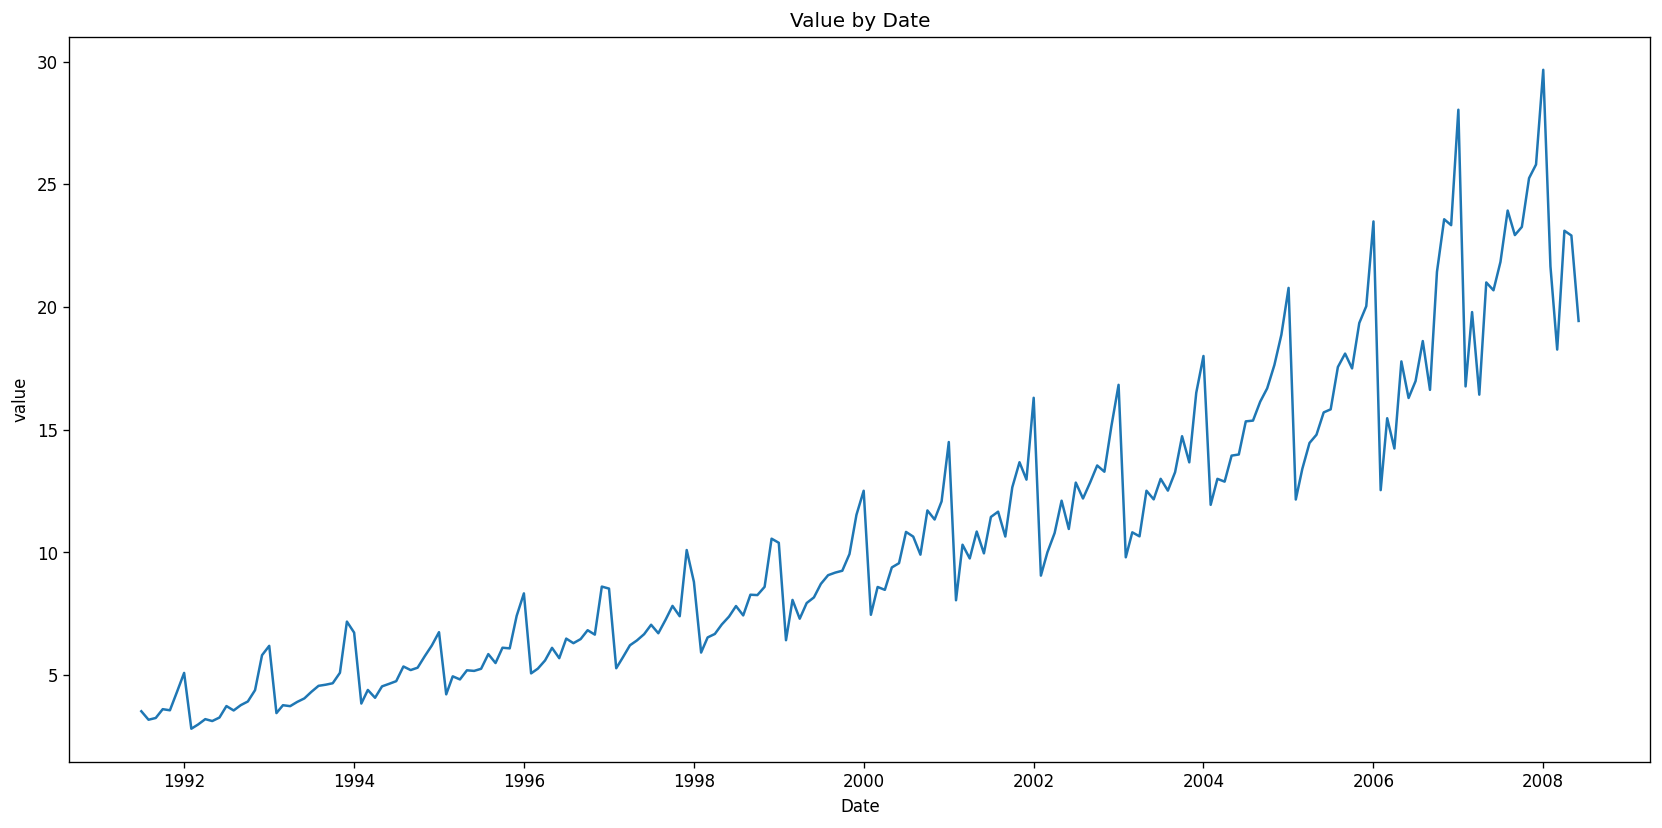

In [ ]:
# visualizing the data
plt.figure(figsize = (17,8))
plt.plot(df)
plt.xlabel('Date')
plt.ylabel("value")
plt.title("Value by Date")
plt.show()

At first glance, there looks to be a positive trend and some sort of seasonality or cyclicity in the dataset. There does not appear to be any major irregularities or noise in the data.

Rolling Statistics

A rolling average is a great way to visualize how the dataset is trending. As the dataset provides counts by month, a window size of 12 will give us the annual rolling average.

We will also include the rolling standard deviation to see how much the data varies from the rolling average.

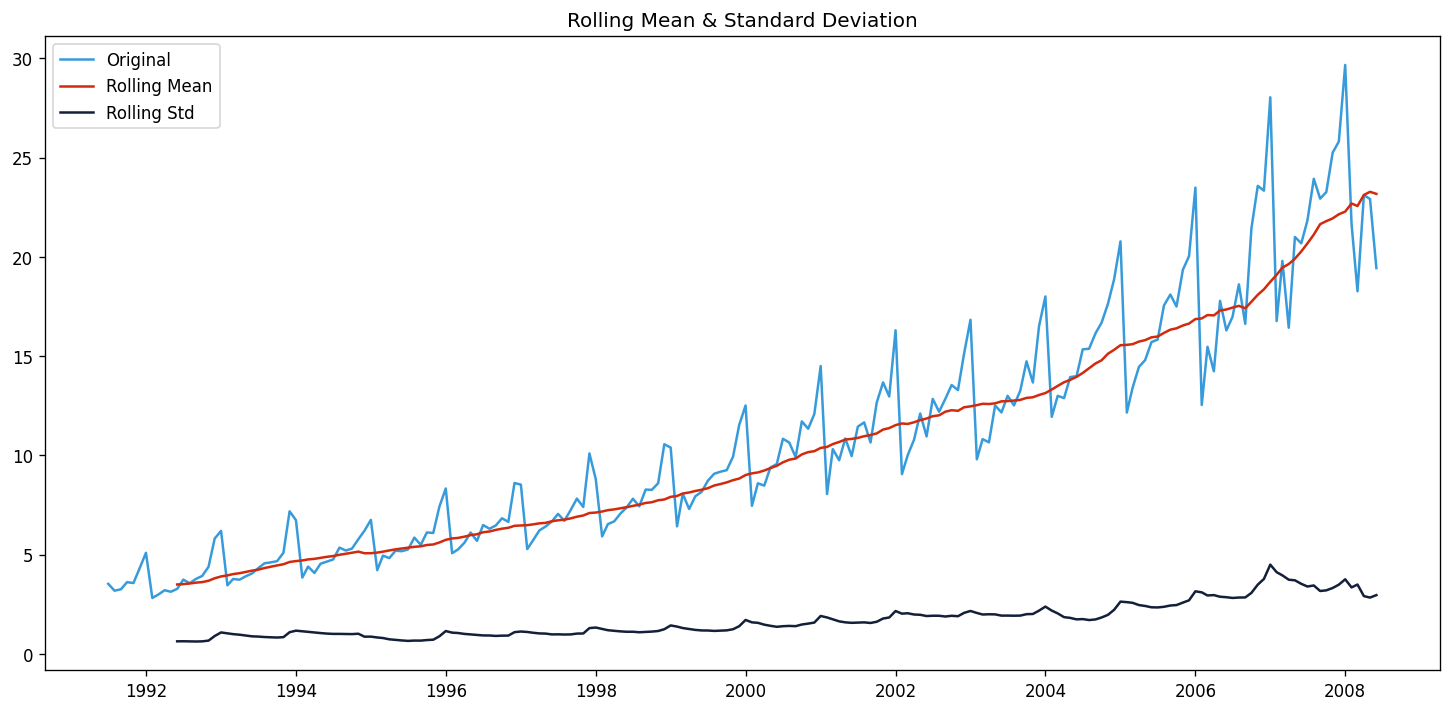

In [ ]:
# Determine the rolling statistics
df["rolling_avg"] = df["value"].rolling(window = 12).mean()
# window size 12 denoted 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["value"].rolling(window = 12).std()

# plot rolling statistics
plt.figure(figsize = (15,7))
plt.plot(df["value"],color="#379BDB", label = "Original")
plt.plot(df["rolling_avg"],color = "#D22A0D", label = "Rolling Mean")
plt.plot(df["rolling_std"],color = "#142039", label = "Rolling Std")
plt.legend(loc = 'best')
plt.title("Rolling Mean & Standard Deviation")
plt.show(block = False)

Augmented Dickey–Fuller Test

The Augmented Dickey-Fuller Test is used to determine if time-series data is stationary or not. Similar to a t-test, we set a significance level before the test and make conclusions on the hypothesis based on the resulting p-value.

p-value <= significance level (0.01, 0.05, 0.10, etc.)

If the p-value is greater than the significance level then we can say that it is likely that the data is not stationary.

In [ ]:
# Augmented Dickey-Fuller Test:

print("Result of Dickey Fuller Test: ")
dftest = adfuller(df["value"],autolag = "AIC")
dfoutput = pd.Series(dftest[0:4], index =["Test Statistics", "p-value",
                                         "#Lags Used", "Number of observation Used"])

for key, value in dftest[4].items():
    dfoutput["Critical value (%s) "%key] = value
    
print(dfoutput)

Result of Dickey Fuller Test: 
Test Statistics                 3.145186
p-value                         1.000000
#Lags Used                     15.000000
Number of observation Used    188.000000
Critical value (1%)            -3.465620
Critical value (5%)            -2.877040
Critical value (10%)           -2.575032
dtype: float64


We can see in the ADF test that the p-value is 1.00000, meaning that it is very likely that the data is not stationary.

since p-value(1.00) is greater than the significance level(0.05), let's difference the series and see how the autocorrelation plot looks like.

In [ ]:
df=df1.copy()
df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


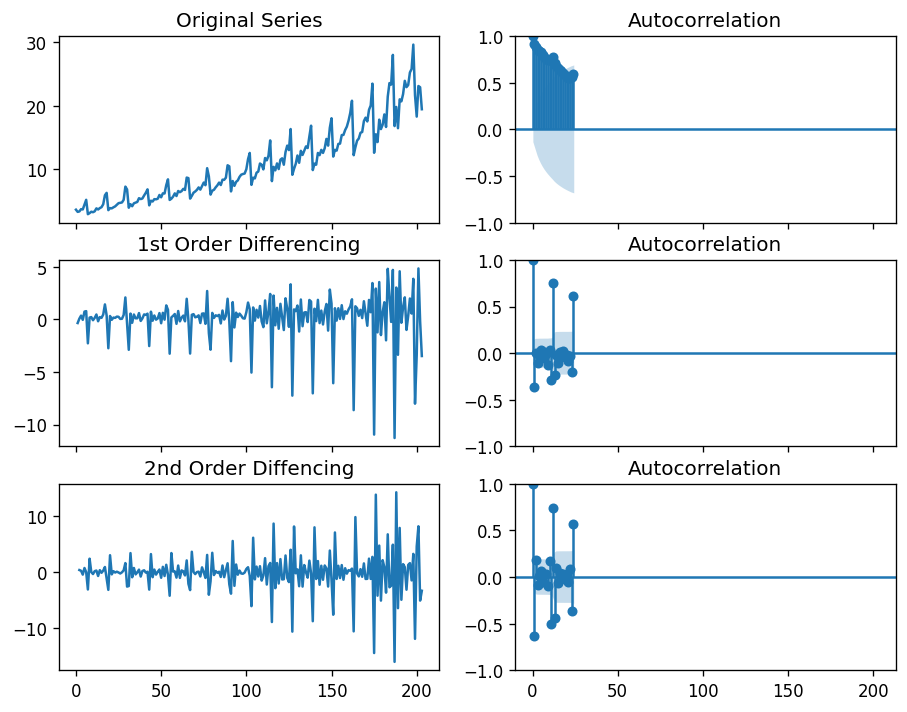

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

#1st Differencing
axes[1,0].plot(df.value.diff())
axes[1,0].set_title("1st Order Differencing")
plot_acf(df.value.diff().dropna(), ax = axes[1,1])

#2nd Differencing
axes[2,0].plot(df.value.diff().diff())
axes[2,0].set_title("2nd Order Diffencing")
plot_acf(df.value.diff().diff().dropna(), ax = axes[2,1])
plt.show()

From the above plot we can see that the time series reaches stationay
with two orders of differencing.

PACF plot to find the order of the AR term(p)

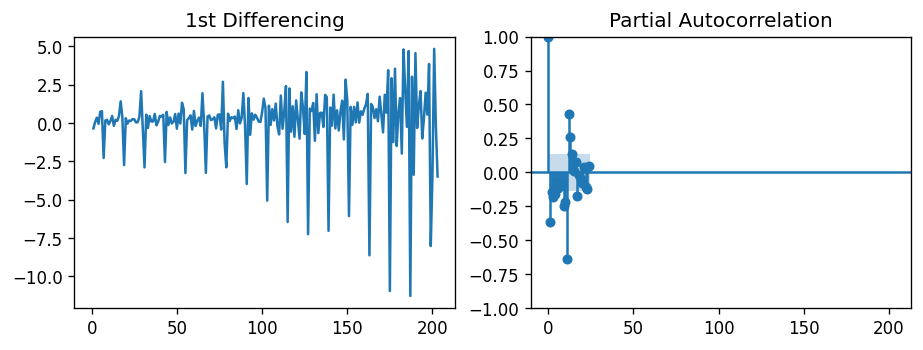

In [ ]:
#PACF plot of 1st differenced series
plt.rcParams.update({"figure.figsize": (9,3), "figure.dpi":120})

fig,axes = plt.subplots(1,2, sharex = True)
axes[0].plot(df.value.diff())
axes[0].set_title("1st Differencing")
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(),method="ywm",ax = axes[1]) # ywm = yule walker method
plt.show()

From the above plot, PACF lag 1 is quite significant since it is well above the signifance line. So, we will fix the value of p as 1

ACF plot to find the order of MA(q)

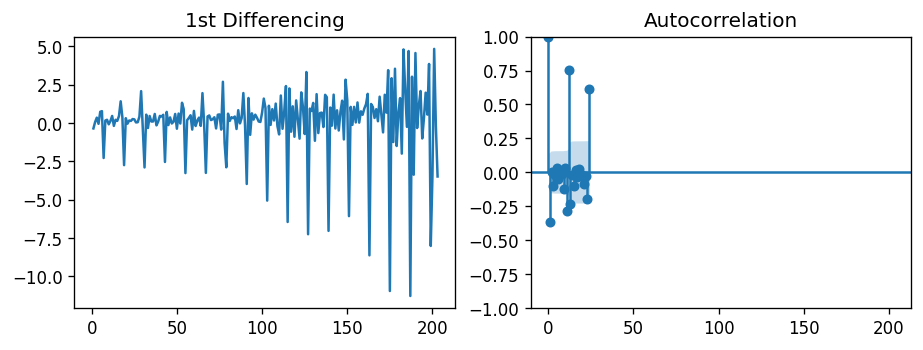

In [ ]:
#ACF plot of 1st differenced series
plt.rcParams.update({"figure.figsize": (9,3), "figure.dpi":120})

fig,axes = plt.subplots(1,2, sharex = True)
axes[0].plot(df.value.diff())
axes[0].set_title("1st Differencing")
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(),ax = axes[1])
plt.show()

From the above plot we can see that couple of lags are well above the significance line. so we fix q as 2.

How to handle if a time series is slightly under or over differenced 
Table of Contents

1. It may happen that the time series is slightly under differenced. Differencing it one more time makes it slightly over-differenced.

2. If the series is slightly under differenced, adding one or more additional AR terms usually makes it up. Likewise, if it is slightly over-differenced, we will try adding an additional MA term.

# ARIMA MODEL

Now, we have determined the values of p, d, q.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df.value, order = (1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -424.570
Date:                Sun, 27 Nov 2022   AIC                            857.140
Time:                        01:38:35   BIC                            870.393
Sample:                             0   HQIC                           862.502
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4178      0.356      1.174      0.240      -0.280       1.115
ma.L1         -0.9546      0.377     -2.531      0.011      -1.694      -0.215
ma.L2          0.0969      0.272      0.356      0.7

The coefficient of the MA2 term is close to zero and P-value in 'P>|z|' column is highly insignificant. It should ideally be less than 0.05 for the respective X to be significant

so, we will build another model without MA2 term.

In [ ]:
model = SARIMAX(df.value, order = (1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -424.762
Date:                Sun, 27 Nov 2022   AIC                            855.524
Time:                        01:38:53   BIC                            865.463
Sample:                             0   HQIC                           859.545
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3009      0.094      3.195      0.001       0.116       0.485
ma.L1         -0.8300      0.048    -17.204      0.000      -0.925      -0.735
sigma2         3.8327      0.259     14.790      0.0

The model AIC has slighly reduced, which is good. The p-values of the AR1 and MA1 terms have improved and are highly significant (<< 0.05)

Let's plot the residuals to ensure there are no pattern.

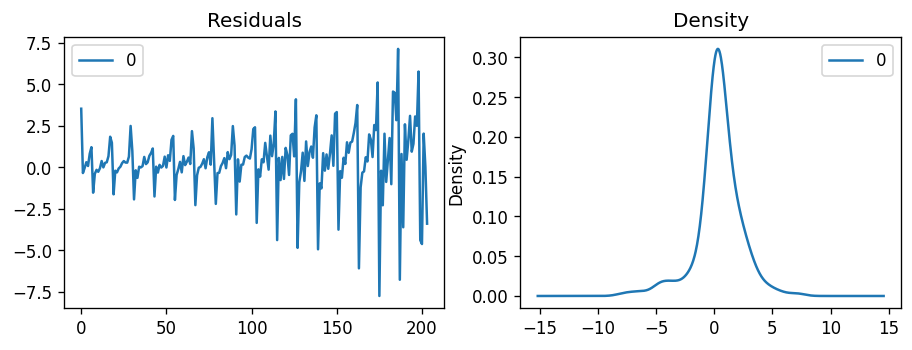

In [ ]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title = "Residuals", ax = ax[0])
residuals.plot(kind = "kde", title = "Density", ax = ax[1])
plt.show()

The residual erros seem fine near zero mean and uniform variance.
let's plot the actual against the fitted values using plot_predict()

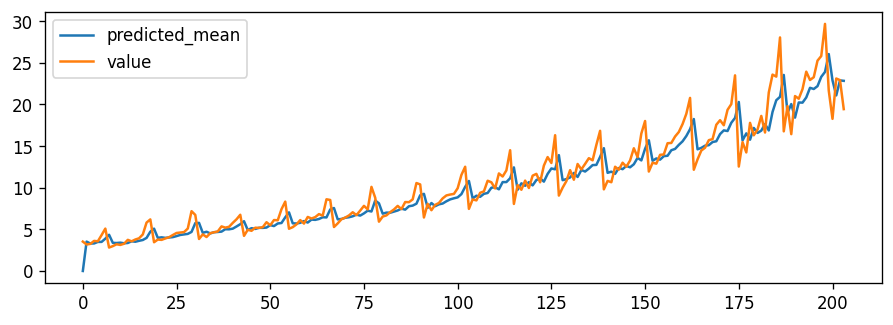

In [ ]:
# Actual Vs Fitted
model_fit.predict(dynamic = False).plot()
df.value.plot()
plt.legend()
plt.show()

When we set dynamic=False the in-sample lagged values are used for prediction. That is, the model gets trained up until the previous value to make the next prediction. This can make the fitted forecast and actuals look artificially good.

So, we seem to have a decent ARIMA model. But, we can’t say that this is the best ARIMA model because we haven’t actually forecasted into the future and compared the forecast with the actual performance.

So, the real validation we need now is the Out-of-Time cross-validation

# optimal ARIMA model using Out of Time Cross Validation

In Out-of-Time cross-validation, we move backwards in time and forecast into the future to as many steps we took back. Then we compare the forecast against the actuals.

To do so, we will create the training and testing dataset by splitting the time series into 2 contiguous parts in a reasonable proportion based on time frequency of series.

In [ ]:
from statsmodels.tsa.stattools import acf
# create Training and Test
train = df.value[:85]
test = df.value[85:]



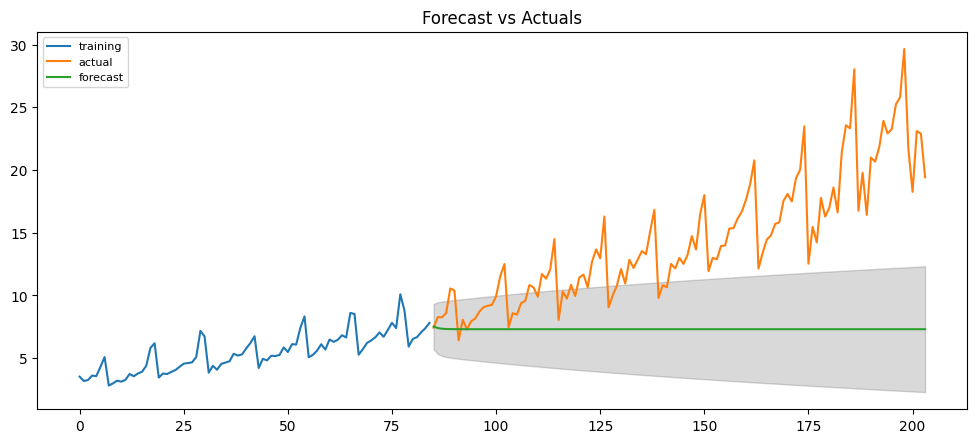

In [ ]:


model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit()  

# Forecast
fc = fitted.get_forecast(119)
fc1 = fc.summary_frame()
conf = fc.conf_int(alpha=0.05)
# Make as pandas series
#fc_series = pd.Series(fc1["mean"], index=test.index)
#print(fc_series)
lower_series = pd.Series(conf["lower value"], index=test.index)
upper_series = pd.Series(conf["upper value"], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc1["mean"], label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()



                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   85
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -116.886
Date:                Sun, 27 Nov 2022   AIC                            243.771
Time:                        03:21:32   BIC                            255.865
Sample:                             0   HQIC                           248.630
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2205      0.194     -1.139      0.255      -0.600       0.159
ar.L2         -0.3436      0.141     -2.444      0.015      -0.619      -0.068
ar.L3         -0.0936      0.252     -0.371      0.7

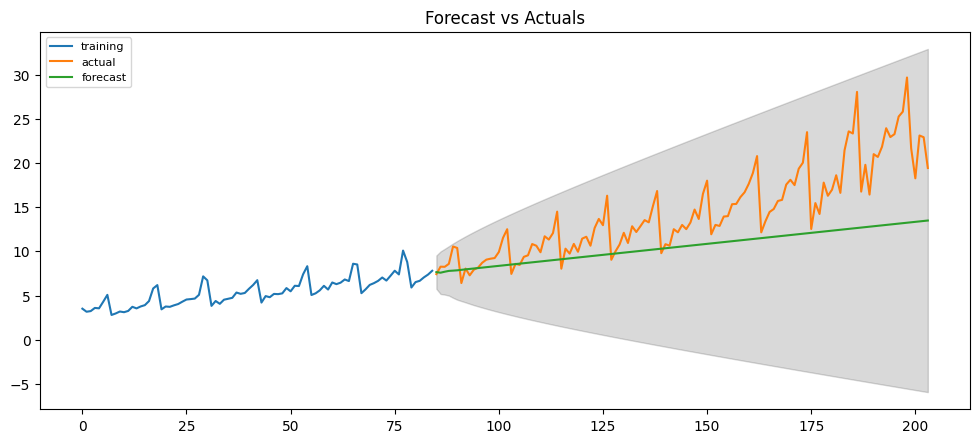

In [ ]:


model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit()  
print(fitted.summary())
# Forecast
fc = fitted.get_forecast(119)
fc1 = fc.summary_frame()
conf = fc.conf_int(alpha=0.05)
# Make as pandas series
#fc_series = pd.Series(fc1["mean"], index=test.index)
#print(fc_series)
lower_series = pd.Series(conf["lower value"], index=test.index)
upper_series = pd.Series(conf["upper value"], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc1["mean"], label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()



# Accuracy metrics for Time series Forecast

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) # MAPE
    me = np.mean(forecast - actual) #ME
    mae = np.mean(np.abs(forecast-actual)) #MAE
    mpe = np.mean((forecast-actual)/actual) # MPE
    rmse = np.mean((forecast -actual)**2) **0.5 #RMSE
    corr = np.corrcoef(forecast,actual)[0,1] # corr
    mins = np.amin(np.hstack([forecast[:,None],
                             actual[:,None]]),axis = 1)
    maxs = np.amax(np.hstack([forecast[:,None],
                             actual[:,None]]),axis = 1)
    
    minmax = 1 - np.mean(mins/maxs)
    acf1 = acf(forecast-test)[1]
    return ({"mape":mape, "me":me, "mae":mae,
            "mpe":mpe, "rmse":rmse, "acf1":acf1,
            "corr":corr, "minmax":minmax})
    
    
forecast_accuracy(fc1["mean"], test.values)

Around 23.26% MAPE implies that the model is 76.74% accurate in predicting the next 15 observation.

# ARIMA MODEL Using pmdarime

In [ ]:
# Standard ARIMA Model
ARIMA_Model = pm.auto_arima(df["value"],
                            start_p=1,
                            start_q=1,
                            test = "adf", # use adftest to find optimal "d"
                            max_p = 3, max_q = 3, # maximum p and q
                            m = 1 , # frequency of series (if m==1, seasonal is set to FALSE automatically)
                            d = None, # let model determine "d"
                            seasonal = False, # No Seasonality for standard ARIMA
                            trace = True, # logs
                            error_action = "warn", # shows error('ignore' silences these)
                            suppress_warnings= True,
                            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=874.416, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1602.665, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=913.571, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1392.713, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=865.809, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=867.147, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=871.437, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=868.483, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=858.292, Time=0.25 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=859.374, Time=0.25 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=860.865, Time=0.33 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit 

In [ ]:
ARIMA_Model

ARIMA(order=(3, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
print(ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  204
Model:               SARIMAX(3, 0, 2)   Log Likelihood                -423.146
Date:                Sun, 27 Nov 2022   AIC                            858.292
Time:                        03:49:18   BIC                            878.201
Sample:                             0   HQIC                           866.345
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3669      0.104      3.536      0.000       0.164       0.570
ar.L2          0.9964      0.038     26.265      0.000       0.922       1.071
ar.L3         -0.3639      0.090     -4.048      0.0

Model Diagnostics


Four plots result from the plot_diagnostics function. The Standardized residual, Histogram plus KDE estimate, Normal q-q, and the correlogram.

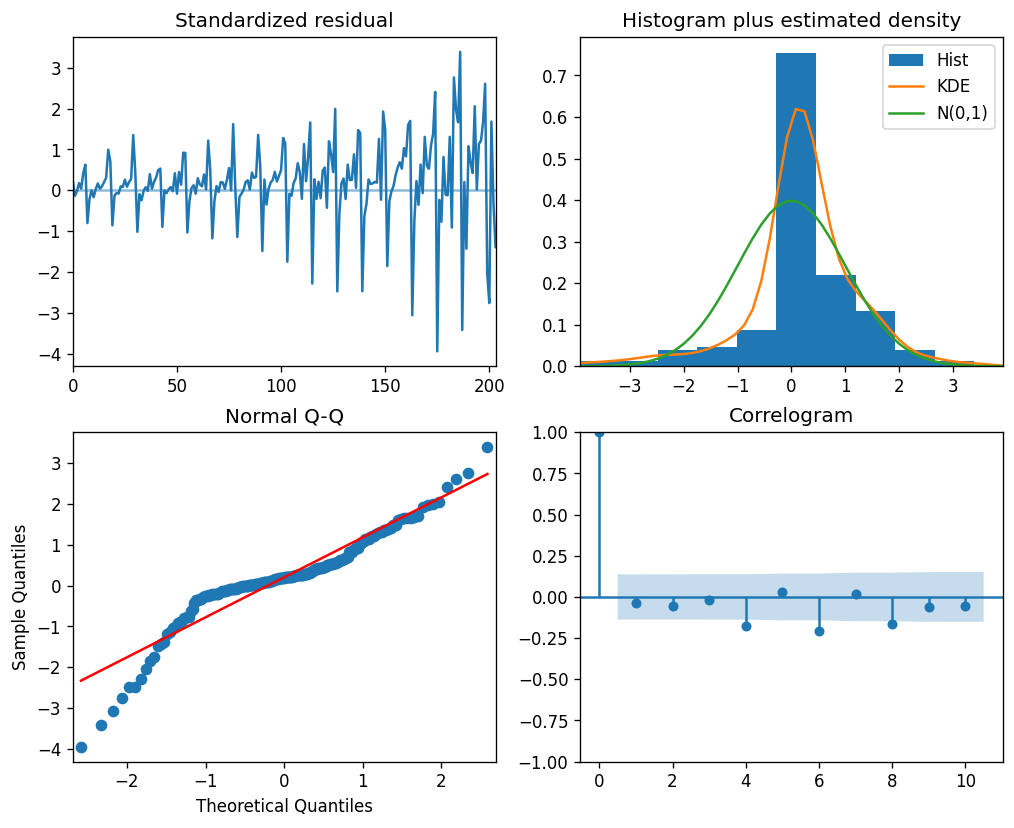

In [ ]:
ARIMA_Model.plot_diagnostics(figsize =(10,8))
plt.show()

We can interpret the model as a good fit based on the following conditions.

Standardized residual

There are no obvious patterns in the residuals, with values having a mean of zero and having a uniform variance.

Histogram plus KDE estimate

The KDE curve should be very similar to the normal distribution (labeled as N(0,1) in the plot)

Normal Q-Q

Most of the data points should lie on the straight line

Correlogram (ACF plot)

95% of correlations for lag greater than zero should not be significant. The grey area is the confidence band, and if values fall outside of this then they are statistically significant. In our case, there are a few values outside of this area, and therefore we may need to add more predictors to make the model more accurate

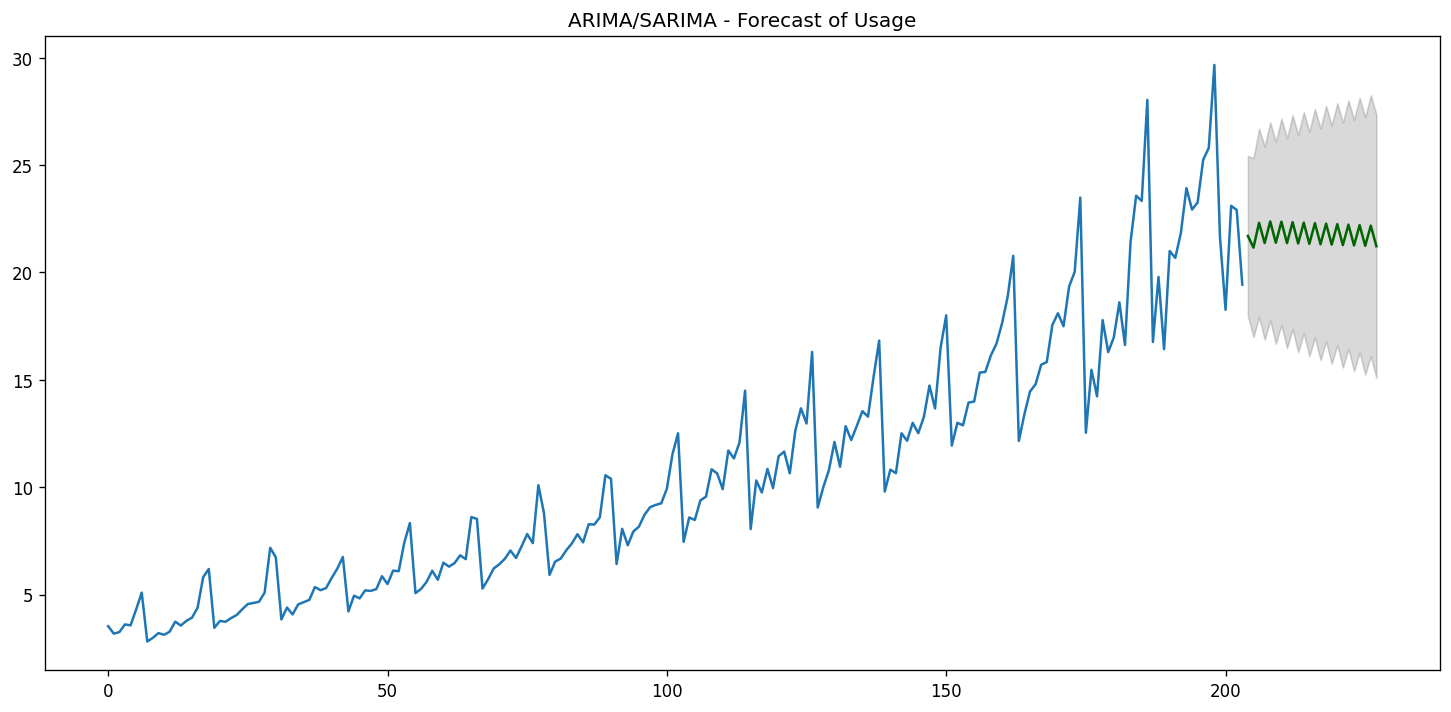

In [ ]:
def forecast(ARIMA_model, periods = 24):
    # forecast 
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods = n_periods, return_conf_int=True)
    index_of_fc = np.arange(len(df.value),len(df.value)+n_periods)
    
    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series =  pd.Series(confint[:,0], index = index_of_fc)
    upper_series = pd.Series(confint[:,1], index = index_of_fc)
    
    # plot
    plt.figure(figsize=(15,7))
    plt.plot(df["value"],color="#1f76b4")
    plt.plot(fitted_series,color="darkgreen")
    plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     color="k",alpha=0.15)
    
    plt.title("ARIMA/SARIMA - Forecast of Usage")
    plt.show()
    
forecast(ARIMA_Model)

As we can see from the plot, this doesn’t seem to be a very accurate forecast. Maybe we need to change the model structure so that it takes into account seasonality?

# SARIMA model in python


Now let’s try the same strategy as we did above, except let’s use a SARIMA model so that we can account for seasonality.

In [ ]:
data = pd.read_csv("arima_dataset.txt",parse_dates=["date"],index_col = "date")
data.head()


,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


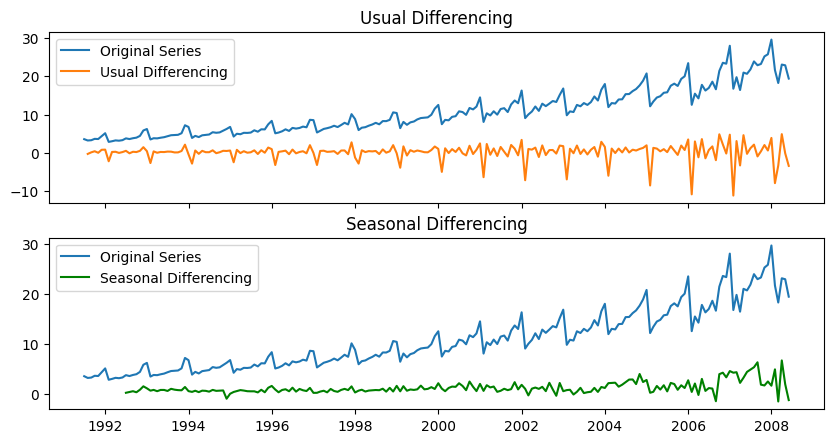

In [ ]:
#plot 
fig, axes = plt.subplots(2,1,figsize=(10,5),dpi = 100, sharex = True)

# usual differencing 
axes[0].plot(data[:], label = "Original Series")
diff1 = data[:]- data[:].shift(1)
axes[0].plot(diff1[1:],label = "Usual Differencing")
axes[0].set_title("Usual Differencing")
axes[0].legend(loc="upper left", fontsize = 10)


# seasonal differencing 
axes[1].plot(data[:], label = "Original Series")
diff12 = data[:]- data[:].shift(12)
axes[1].plot(diff12[12:],label = "Seasonal Differencing",color = "green")
axes[1].set_title("Seasonal Differencing")
axes[1].legend(loc="upper left", fontsize = 10)
plt.show()

from the above plot we can see that the seasonal spikes are intact after applying usual differencing (lag1). whereas, it is rectified after seasonal differencing.

In [ ]:
# seasonal - fit setwise auto-ARIMA
SARIMA_model = pm.auto_arima(data,
                                start_p=1,
                                start_q=1,
                                test="adf",
                                max_p=3,max_q=3,
                                m=12, # 12 is the frequency of cycle
                                start_P = 0,
                                seasonal=True, # set the seasonal
                                d=None,
                                D = 1, # order of the seasonal differencing
                                trace = True,
                                error_action = 'ignore',
                                suppress_warinings = True,
                                stepwise = True)
                                

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=534.818, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=624.061, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=596.068, Time=0.21 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=611.475, Time=0.13 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=757.274, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=559.407, Time=0.14 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=536.817, Time=2.04 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=543.106, Time=0.47 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=537.730, Time=2.60 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=594.467, Time=0.15 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=529.829, Time=0.50 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=555.198, Time=0.18 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.19 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

In [ ]:
SARIMA_model

ARIMA(order=(1, 0, 2), scoring_args={}, seasonal_order=(1, 1, 2, 12),
      suppress_warnings=True)

In [ ]:
print(SARIMA_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(1, 0, 2)x(1, 1, 2, 12)   Log Likelihood                -253.952
Date:                            Sun, 27 Nov 2022   AIC                            523.903
Time:                                    04:13:41   BIC                            549.963
Sample:                                07-01-1991   HQIC                           534.458
                                     - 06-01-2008                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0053      0.009      0.585      0.559      -0.012       0.023
ar.L1          0.9766      0.018   

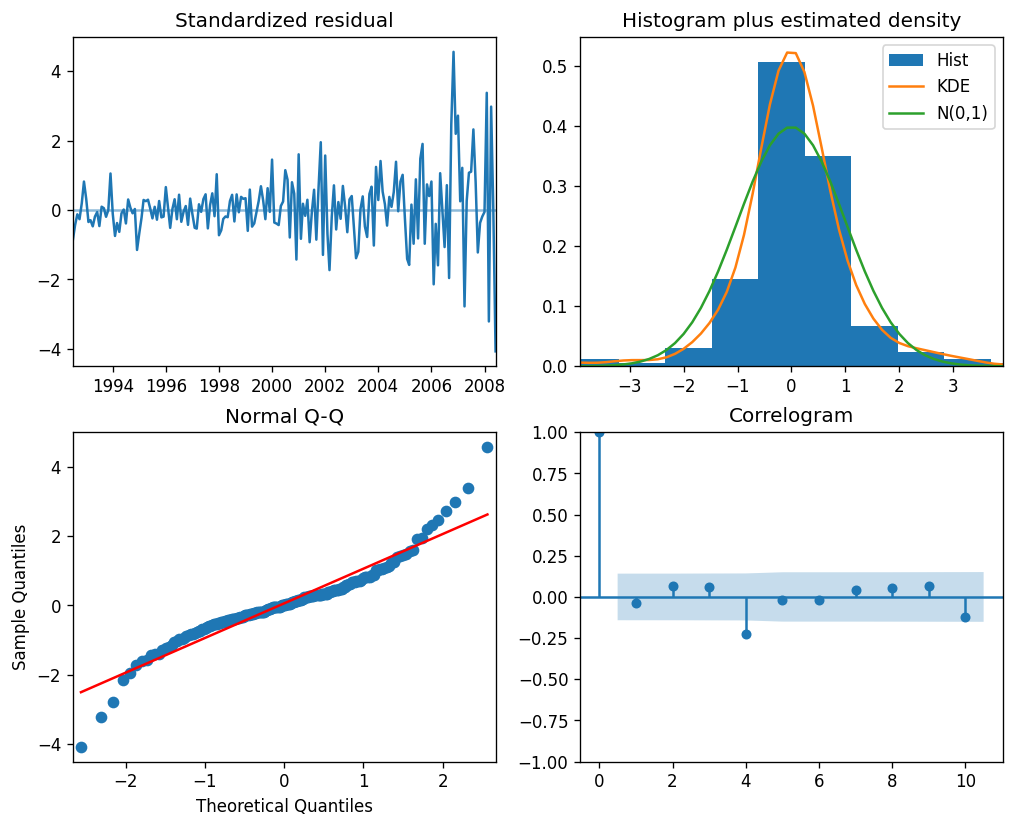

In [ ]:
# model diagonostics
SARIMA_model.plot_diagnostics(figsize =(10,8))
plt.show()

Taking a look at the model diagnostics, we can see some significant differences when compared with the standard ARIMA model.

Standardized residual

The Standardized residual is much more consistent across the graph, meaning that the data is closer to being stationary.

Histogram plus KDE estimate

The KDE curve is similar to the normal distribution (not much changed here).

Normal Q-Q

The data points are clustered much closer to the line than in the ARIMA diagnostic plot.

Correlogram (ACF plot)

The grey area is the confidence band, and if values fall outside of this then they are statistically significant. We want all values inside this area. Adding the seasonality component did this! couple of points still fall outside of  the 95% confidence interval.

making a forecast of 24 months

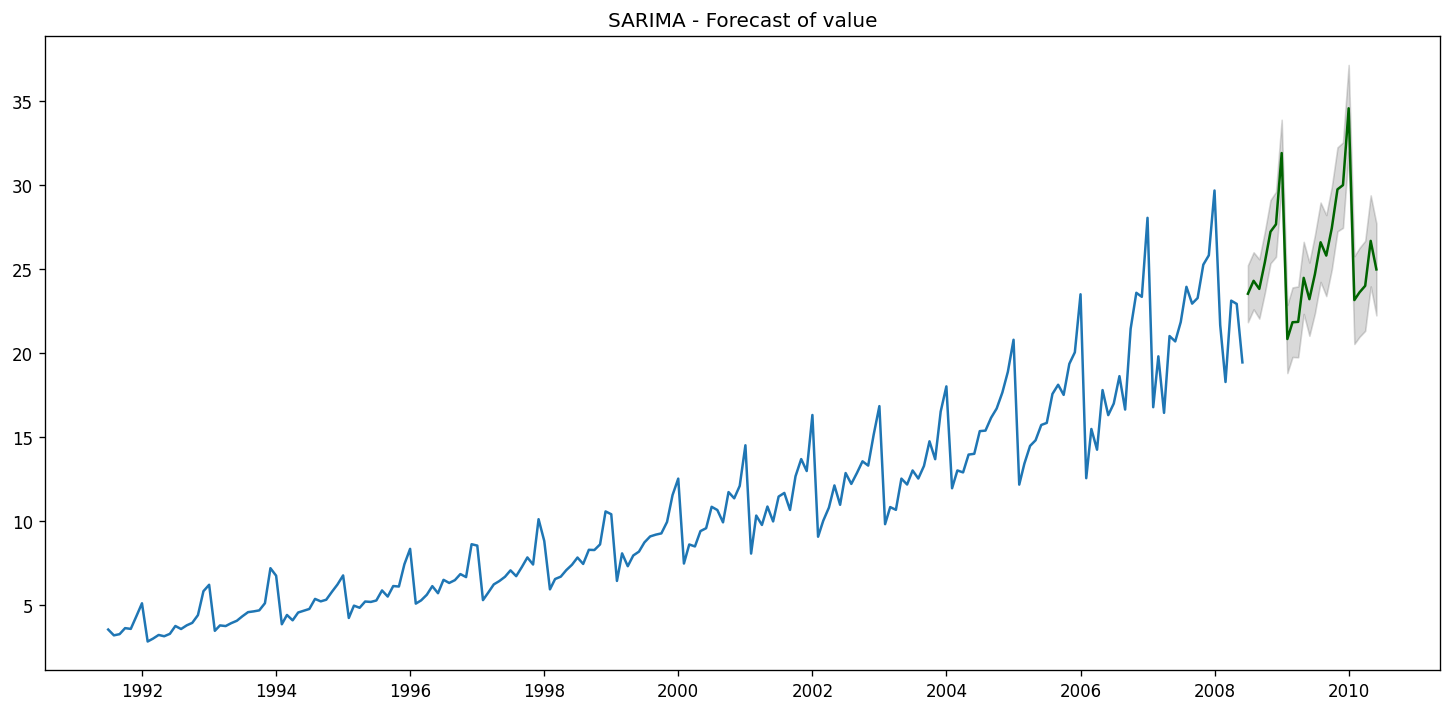

In [ ]:
def forecast(ARIMA_model, periods = 24):
    # forecast 
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods = n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(data.index[-1] + pd.DateOffset(months=1),periods=n_periods,freq="MS")
    
    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series =  pd.Series(confint[:,0], index = index_of_fc)
    upper_series = pd.Series(confint[:,1], index = index_of_fc)
    
    # plot
    plt.figure(figsize=(15,7))
    plt.plot(data,color="#1f76b4")
    plt.plot(fitted_series,color="darkgreen")
    plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     color="k",alpha=0.15)
    
    plt.title("SARIMA - Forecast of value")
    plt.show()
    
forecast(SARIMA_model)

From the above plot the model captures the expected seasonal demand pattern.